# 4-9. 프로젝트 : 주식 예측에 도전해 보자

ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세입니다. 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다.

우선 주요 라이브러리 버전을 확인해 봅시다.

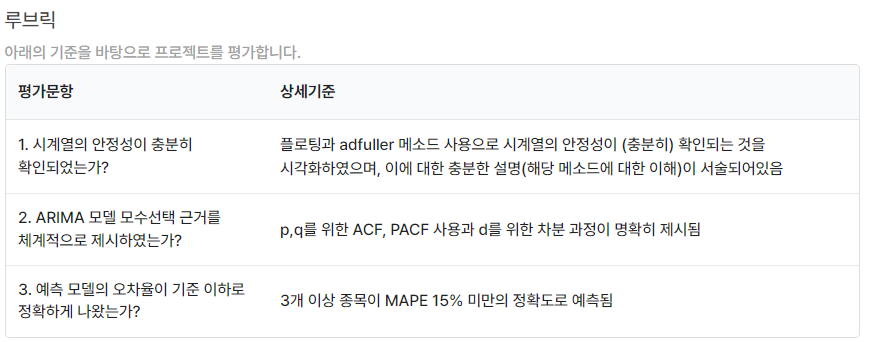

In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.4.4
1.0.2
0.13.2


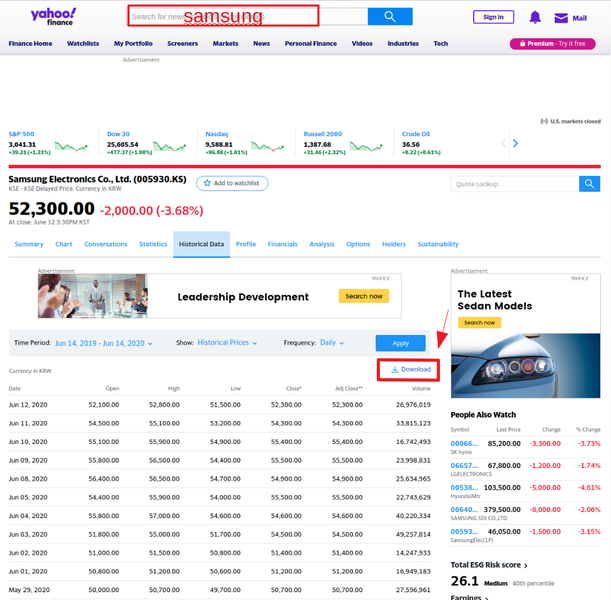

위 그림과 같이 [Yahoo Finance](https://finance.yahoo.com/)에서 오늘 사용할 데이터셋을 다운로드할 수 있습니다.

하지만 이전 스텝을 차근차근 진행하셨다면, 이미 데이터셋이 stock_prediction/data 에 올라와 있을 것입니다.
아래 명령어로 005930.KS.csv 파일이 존재하는지 확인해 봐요

### STEP 1 : 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()
```

In [2]:
# pip install yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 직접받아 오는 것은 김지수님 코드
import yfinance as yf
data = yf.download('005930.KS', start='2020-05-18', end='2021-05-18')
data.info()

data.head()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2020-05-18 to 2021-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       249 non-null    float64
 1   High       249 non-null    float64
 2   Low        249 non-null    float64
 3   Close      249 non-null    float64
 4   Adj Close  249 non-null    float64
 5   Volume     249 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.6 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,45325.941406,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,46719.160156,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,46440.511719,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,46394.070312,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,45279.500000,19706284


- 결측치는 보이지 않는다. 

### STEP 2 : 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

```python
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 로그 변환 시도 
ts_log = np.log(ts)
```

- 그래프로 확인

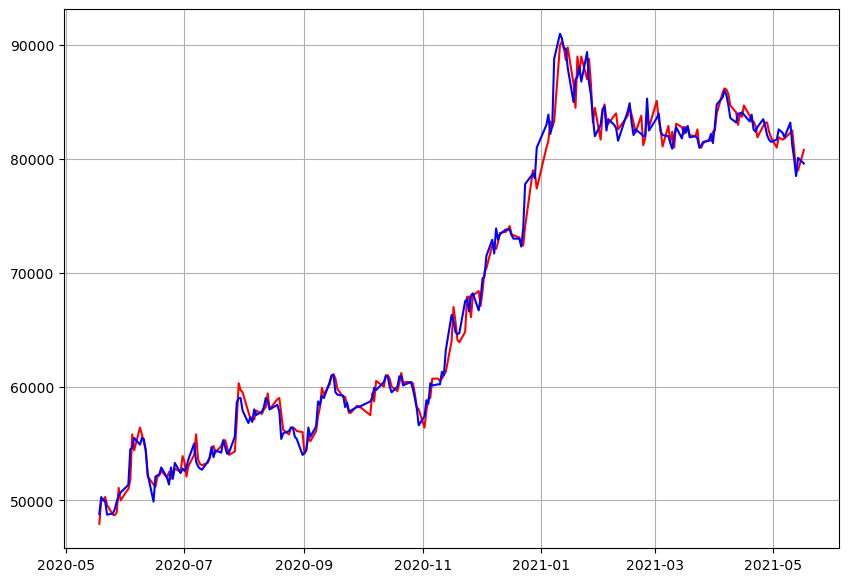

In [9]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(data['Open'], c = 'r', label = 'Open Price')
plt.plot(data['Close'], c = 'b', label = 'Close Price')
plt.legend
plt.show()

- 로그 변환 시도

In [12]:
data_log = np.log(data)
data_log.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,10.777914,10.801614,10.770588,10.795486,10.721635,16.835056
2020-05-19,10.821776,10.829729,10.813760,10.825760,10.751910,17.041096
2020-05-20,10.819778,10.823770,10.815770,10.819778,10.745927,16.516664
2020-05-21,10.825760,10.827746,10.816774,10.818778,10.744927,16.520173
2020-05-22,10.811746,10.815770,10.791379,10.794460,10.720610,16.796448


- 시각화

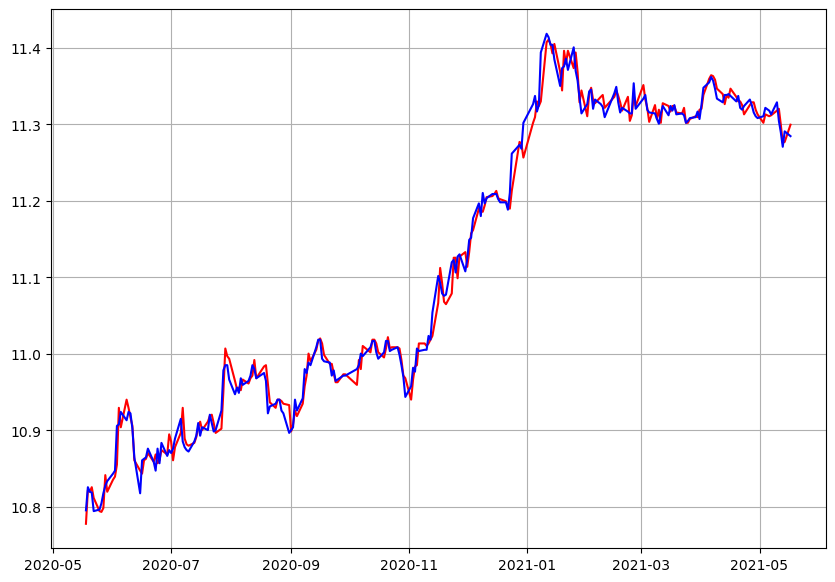

In [14]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(data_log['Open'], c = 'r', label = 'Open Price')
plt.plot(data_log['Close'], c = 'b', label = 'Close Price')
plt.legend
plt.show()

- 이동평균, 이동 표준편차를 그래프로 확인해본다. 

In [16]:
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

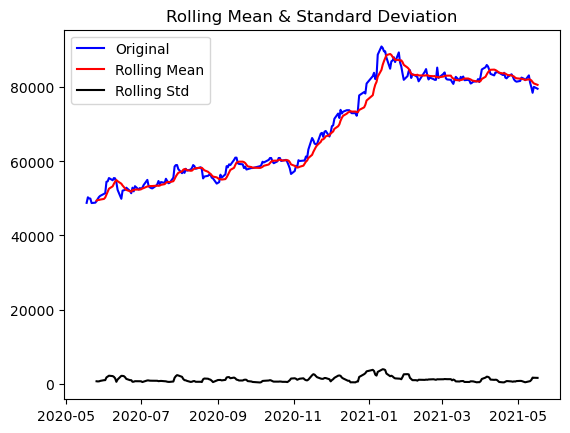

In [19]:
plot_rolling_statistics(data['Close'], window=7)

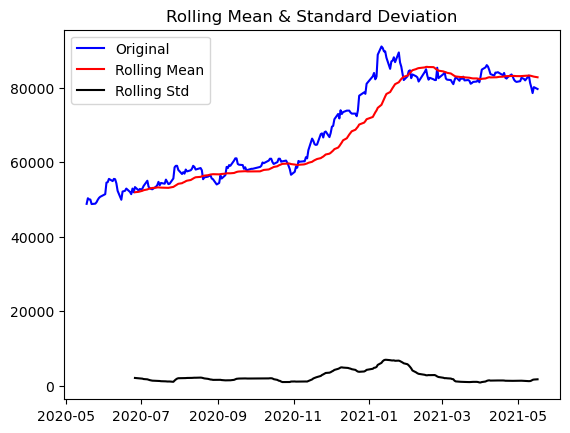

In [20]:
plot_rolling_statistics(data['Close'], window=30)

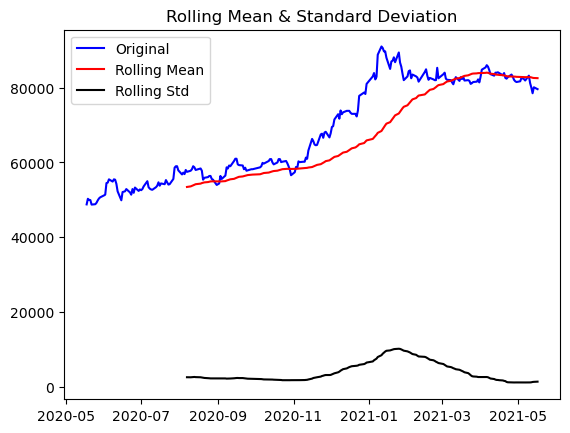

In [22]:
plot_rolling_statistics(data['Close'], window=60)

### STEP 3 : 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

```python
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
```

In [23]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [25]:
augmented_dickey_fuller_test(data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.216246
p-value                          0.666568
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [27]:
augmented_dickey_fuller_test(data_log['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.376439
p-value                          0.593518
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


- log화로 p-value가 새 모이만치 줄어든걸 볼수 있다. 

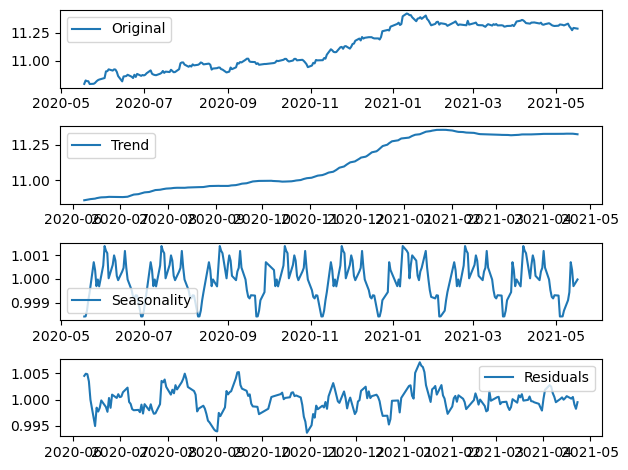

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log['Close'], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 기간을 달리하면 그려본다. 

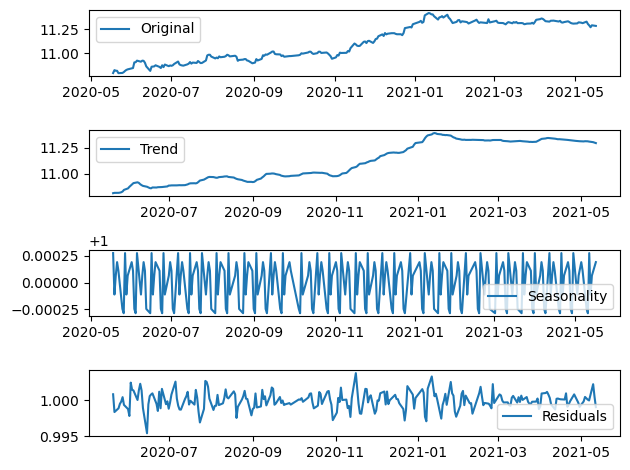

In [35]:
decomposition = seasonal_decompose(data_log['Close'], model='multiplicative', period = 7) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

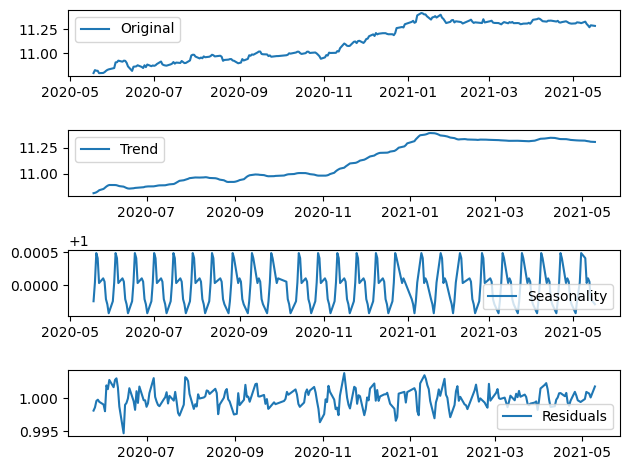

In [36]:
decomposition = seasonal_decompose(data_log['Close'], model='multiplicative', period = 10) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 기간을 10일로 설정하는 것이 뭔가 더 stationary 하게 해 줄수 있을 것 같다. 

In [37]:
# 본격적으로 안정적으로 가공하기 위해 새로운 변수 할당한다. 
data_log_close = data_log['Close']

```python
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
```

In [44]:
decomposition = seasonal_decompose(data_log_close, model='multiplicative', period = 10) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.003783e+01
p-value                        1.524009e-17
#Lags Used                     3.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


In [45]:
decomposition = seasonal_decompose(data_log_close, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.181353e+00
p-value                        6.443658e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


In [46]:
decomposition = seasonal_decompose(data_log_close, model='multiplicative', period = 7) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.777134e+00
p-value                        6.886953e-17
#Lags Used                     5.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


- 예상이 맞았다. 10일을 시즈널 기간으로 해서 계속 진행한다. 

In [48]:
decomposition = seasonal_decompose(data_log_close, model='multiplicative', period = 10) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.003783e+01
p-value                        1.524009e-17
#Lags Used                     3.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


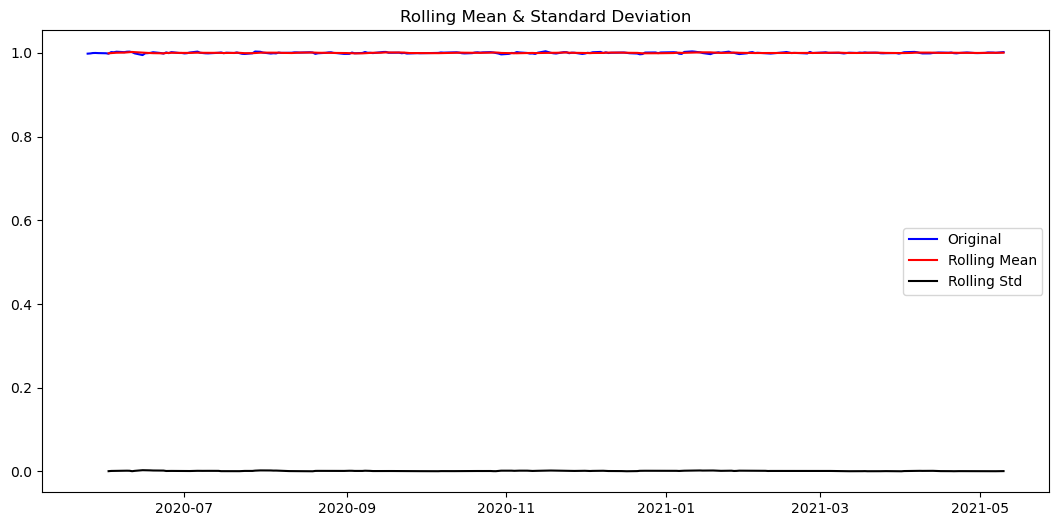

In [49]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

- 뭔가 그래프가 어처구니 없지만 일단 진행해본다. 

### STEP 4 : 학습, 테스트 데이터셋 생성
----
- 학습, 테스트 데이터셋 분리

```python
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
```

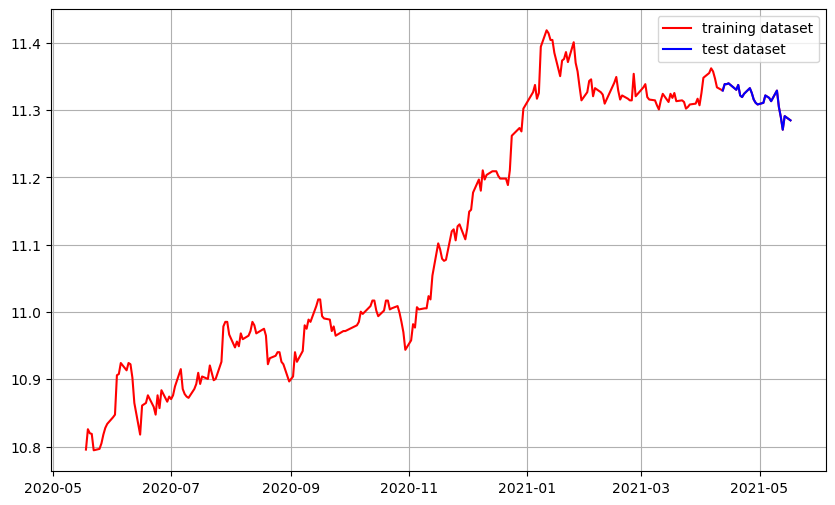

In [54]:
train_data, test_data = data_log_close[:int(len(data_log_close)*0.9)], data_log_close[int(len(data_log_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(data_log_close, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기
----
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

```pthon
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()
```

In [ ]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

C:\Users\aeoli\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


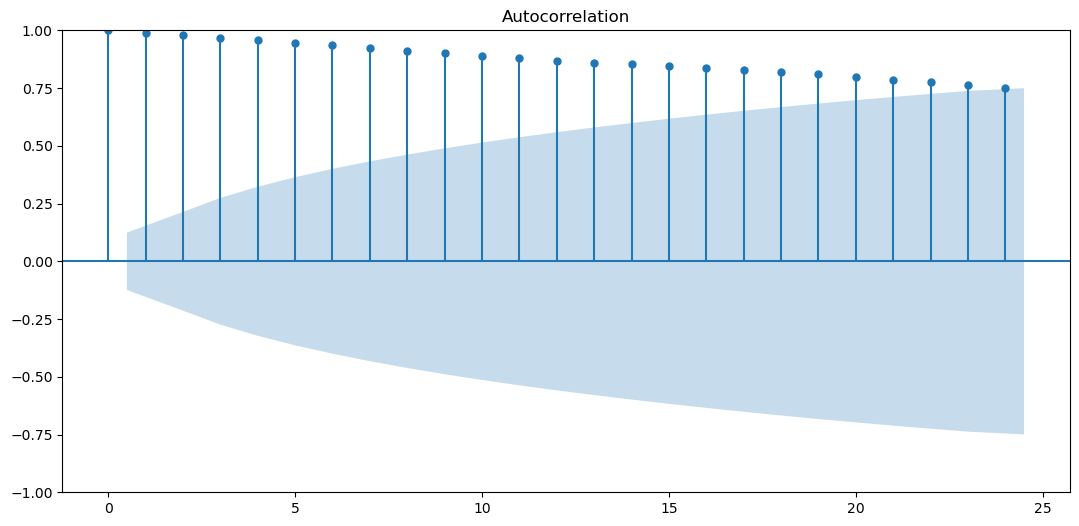

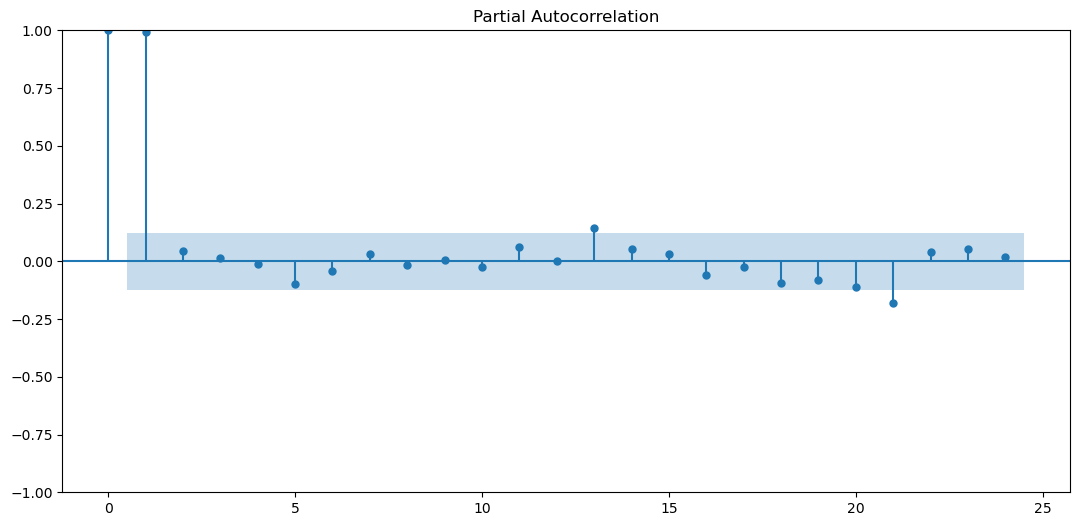

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_log_close)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(data_log_close)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

```python
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
```

<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Date'>

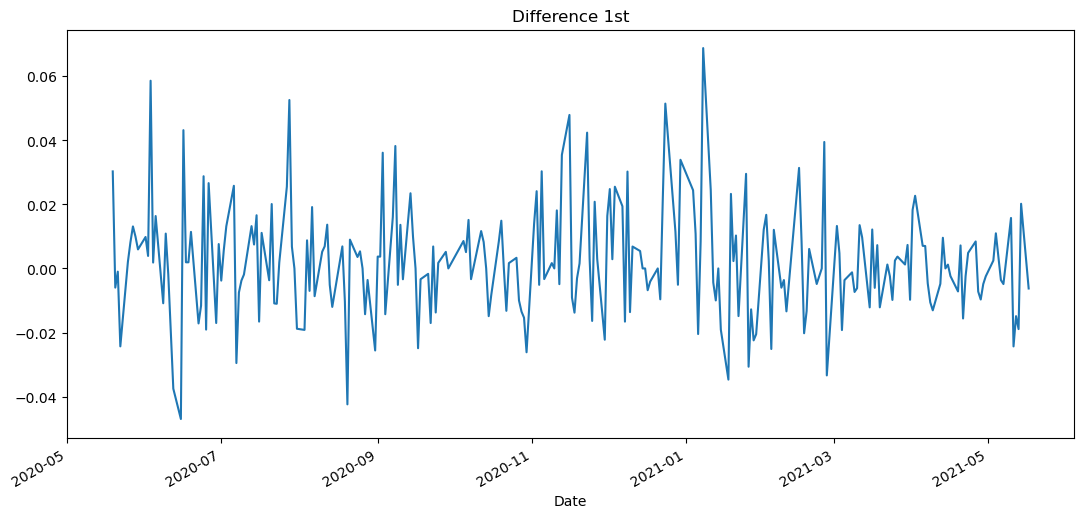

In [65]:
# 1차 차분 구하기
diff_1 = data_log_close.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

In [66]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
diff_1.dropna(inplace=True)
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.550157e+01
p-value                        2.411857e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


- 어마어마 한 값이 나왔다

### STEP 6 : ARIMA 모델 훈련과 테스트
---
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

```python
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())
```

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]

```python
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()
```

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

# Make as pandas series
# [[YOUR CODE]]

# Plot
# [[YOUR CODE]]

```python
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
```

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = # [[YOUR CODE]]
print('MSE: ', mse)

mae = # [[YOUR CODE]]
print('MAE: ', mae)

rmse = # [[YOUR CODE]]
print('RMSE: ', rmse)

mape = # [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

### STEP 7 : 다른 주식 종목 예측해 보기
---
관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

In [ ]:
# [[YOUR CODE]]